In [1]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Create color maps
cmap_list = ['orange', 'cyan', 'cornflowerblue']
cmap_bold = ['darkorange', 'c', 'darkblue']
cmap_light = ListedColormap(cmap_list)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Ensemble methods

In this notebook we are going to explore several ensemble methods, which will augment what's covered in the homework assignment.  Recently we've been focusing on our own models and code to illustrate what's going on under the hood.  However in this notebook we will rely heavily on scikit-learn to help you learn about the many existing tools that can be deployed with very little effort.  The key is to know what you're getting into!

We will continue to focus on linear models.  We'll use the linear regression module from scikit-learn as it's going to make it easier to interface to the ensemble methods here.  Using the ```sklearn.model_selection``` module we will use:

  * Train-test splitting
  * K-fold  & Repeated K-fold splitting
  * Leave one out (LOO) and leave P out (LPO)
  * Random permutations
  * Grouped data methods
  
***
***
# First, let's make some data

(0.7650873537452108, 2.9267446246827395)

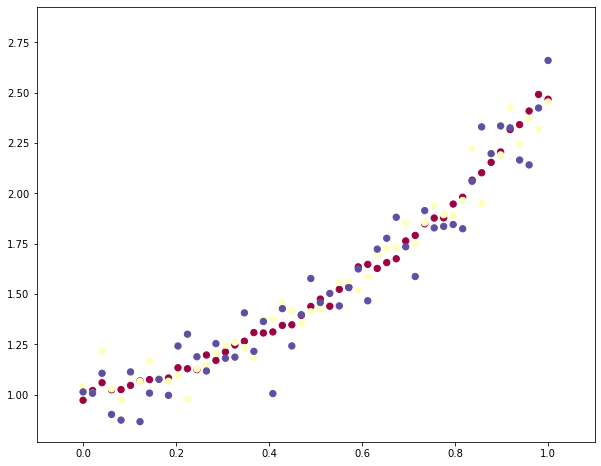

In [2]:
np.random.seed(111)

N = 50 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes

X = np.zeros((N*K,D))
labels = np.zeros(N*K, dtype='uint8')

for j in range(K):
    ix = range(N*j,N*(j+1))
    xx = np.linspace(0,1,N)

    # Same data, just gets noisier with each class
    yy = 1+0.5*xx + 0.5*xx**2 + 0.5*xx**3 + np.random.randn(N)*(0.025+j*0.05)
    
    X[ix] = np.c_[xx,yy]
    labels[ix] = j

Xtest = np.linspace(0,1,N)
ytest = 1+0.5*Xtest + 0.5*Xtest**2 + 0.5*Xtest**3

xmin = np.amin(X[:,0])-0.1
xmax = np.amax(X[:,0])*1.1

ymin = np.amin(X[:,1])-0.1
ymax = np.amax(X[:,1])*1.1

#print("Design\n",X)
#print("labels\n",y)

fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap=plt.cm.Spectral)
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

MSE Loss:  0.006502729321432749
True Model MSE Loss:  0.00011183474814876709
Fit Coefficients:  [ 1.02676742 -0.34699195  5.31488691 -9.95608061  9.79822201 -3.3476371 ]


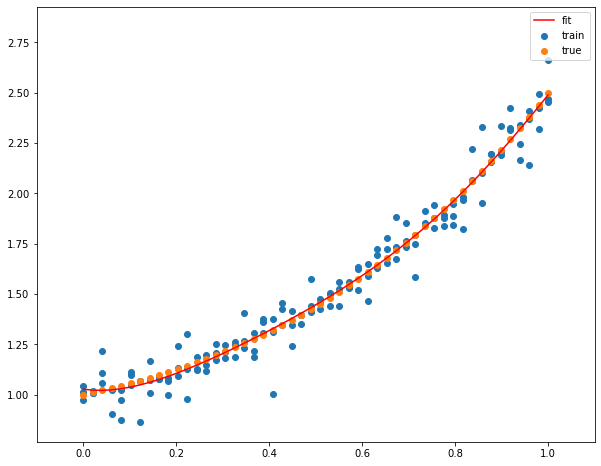

In [6]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

#data is 3rd order poly, so going to 5th order is fine.
nDegr = 5

xt = np.zeros((X[:,0].size,1))
xt[:,0] = X[:,0]

poly = PolynomialFeatures(degree=nDegr)
DM = poly.fit_transform(xt)

xt = np.zeros((Xtest.size,1))
xt[:,0] = Xtest
DMtest = poly.fit_transform(xt)

y = X[:,1]

#print(DM)

# Note that our design matrix includes the bias term, so we need to tell
# the linear_model to not include a bias term. Seems counter-intuitive,
# but fit_intercept=False means to not include the bias term.
lin_mod = linear_model.LinearRegression
regress = lin_mod(fit_intercept=False).fit(DM,y)

pred_y = regress.predict(DM)
loss = mean_squared_error(pred_y,y)
print("MSE Loss: ", loss)

pred_y = regress.predict(DMtest)
loss = mean_squared_error(pred_y,ytest)
print("True Model MSE Loss: ", loss)
print("Fit Coefficients: ",regress.coef_)

#keep track of our fit to all of the data!
Wall = regress.coef_

line = np.dot(DMtest,Wall)
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1],label="train")
plt.scatter(Xtest, ytest,label="true")
plt.plot(Xtest,line,c='red',label="fit")
plt.legend()
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.show()

***
***
# Test/Train Split 

Here we illustrate the method of splitting our sample into just two orthogonal sets.  One for testing and one for training.  The ```test_size``` variable specifies the fraction of the events that go in the test sample, in this case 40%.  Nothing too impressive, so we just leave that here for illustration.

In [7]:
>>> from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print("Original shape: ",X.shape)
print("Split train shape: ",X_train.shape)
print("Split test shape: ",X_test.shape)

Original shape:  (150, 2)
Split train shape:  (90, 2)
Split test shape:  (60, 2)


***
***

# Cross Validation

To study our model quality, we can instead use cross validation.  This is illstrated in the image below from the ```scikit-learn``` website:

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="500"/>

In this case, we will split our training data into N subsets (or mini-batches) and train on each of them individually.  In the homework, you are using this approach to average the values across several fits.  Here we will look at the loss from each of the fits to get a feeling for how much the loss varies within these N subsets.

By default, the "score" reported by the ```cross_val_score``` is the loss function used in your model.  In our case, we used standard linear regression so we have the MSE loss.  But you're not limited to this and you can choose lots of different scoring options:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

The ```cross_val_score``` tools is very important because we can use it with other cross-validation algorithms instead of the vanilla cross validation as illustrated above.  We will look into using a cross validation iterator in the following.

In [8]:
from sklearn.model_selection import cross_val_score


# obtain loss metric info from N=5 cross-validation splits
scores = cross_val_score(regress, DM, y, cv=5,scoring='neg_mean_squared_error')

#convert from negative to positive
scores *= -1
print(scores)
print("Mean loss is %0.2f  with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


# obtain loss metric info from N=5 cross-validation splits
scores = cross_val_score(regress, DM, y, cv=5, scoring='neg_root_mean_squared_error')

print(scores)
print("Mean loss is %0.2f  with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.00062571 0.00294581 0.00324068 0.0106775  0.01720844]
Mean loss is 0.01  with a standard deviation of 0.01
[-0.02501426 -0.0542753  -0.05692699 -0.10333199 -0.13118094]
Mean loss is -0.07  with a standard deviation of 0.04


***
***

# More cross validation!

That was useful, but we only had the losses from our training samples.  If we want to test our variance, we need to have both the training sample and testing samples.  The the way to get that is via the ```KFold``` module.  The module makes N permutations, which can be used to sample your original inputs.

We are choosing ```n_splits=5```, which will create 5 independent testing training sets of size $1/5\times N_{tot}=20\% N_{tot}$.  So we should get 30 events in each of the testing samples, leaving the other 120 for training.

In [9]:
>>> from sklearn.model_selection import KFold

kfold = KFold(n_splits=5)
losses = np.zeros(5)
idx = 0
for train, test in kfold.split(X):
    print(DM[train].shape)
    print(DM[test].shape)
    reg = lin_mod(fit_intercept=False).fit(DM[train],y[train])
    pred_y = reg.predict(DM[test])
    losses[idx] = mean_squared_error(pred_y,y[test])
    print(losses[idx])
    idx = idx+1

print(losses)
print("Mean loss is %0.2f with a standard deviation of %0.2f" %(np.mean(losses),np.var(losses)))

(120, 6)
(30, 6)
0.00062571298193006
(120, 6)
(30, 6)
0.0029458083566181537
(120, 6)
(30, 6)
0.0032406823372622888
(120, 6)
(30, 6)
0.01067749942468679
(120, 6)
(30, 6)
0.01720843859194738
[0.00062571 0.00294581 0.00324068 0.0106775  0.01720844]
Mean loss is 0.01 with a standard deviation of 0.00


***
***

# Leave some out

We can also perform a split that builds samples wherein we've left out a fraction at a time using a N-choose-P permutation.  This is often referred to as "Leave P Out" or LPO.  Unlike the K-Fold version, the testing sets will thus overlap if we use P>1.  This is because for K-Fold cross valication, we use a unique 1/K of the events each time.  For LPO, we have many more ways of choosing the P that get left out.


In [10]:
from sklearn.model_selection import LeavePOut

lpo = LeavePOut(p=75)  #lets leave 50% out for this test

#I'm not going to actually run this because....
print("There were %d ways to leave out half of the sample!!" % lpo.get_n_splits(X))

There were 92826069736708789698985814872605121940117520 ways to leave out half of the sample!!


***
***

# Random splits

We can also take random samplings of the data sample.  The ```ShuffleSplit``` module allows us to create ```n_splits``` samples chosen randomly from the total.  Each sample will contain the fraction ```test_size``` of the total.  For example with ```n_splits=5``` and ```test_size```, we will get 5 samples that each have 75 events.  Because this is random, it's convenient to be able to fix the random state so that the samples are always the same in case you need to debug.


<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0061.png" width="500"/>

In [11]:
from sklearn.model_selection import ShuffleSplit

shuffle = ShuffleSplit(n_splits=5, test_size=0.5, random_state=2237)

losses = np.zeros(5)
idx = 0

for train, test in shuffle.split(X):
    print(DM[train].shape)
    print(DM[test].shape)
    reg = lin_mod(fit_intercept=False).fit(DM[train],y[train])
    pred_y = reg.predict(DM[test])
    losses[idx] = mean_squared_error(pred_y,y[test])
    print(losses[idx])
    idx = idx+1

print(losses)
print("Mean loss is %0.2f with a standard deviation of %0.2f" %(np.mean(losses),np.var(losses)))

(75, 6)
(75, 6)
0.00943584807377894
(75, 6)
(75, 6)
0.007394916669538507
(75, 6)
(75, 6)
0.007833563008285723
(75, 6)
(75, 6)
0.006235282528087772
(75, 6)
(75, 6)
0.010131792982753773
[0.00943585 0.00739492 0.00783356 0.00623528 0.01013179]
Mean loss is 0.01 with a standard deviation of 0.00


***
***

# Group K-Fold (last one!)

Finally, there is a very convenient case in which we can perform K-Fold cross validation using group training/testing.  In our case, we have three classes and it would be interesting to see what we get if we exclude one group at a time from training.



In [12]:
from sklearn.model_selection import GroupKFold

grpFold = GroupKFold(n_splits=3)  # we have 3 classes, so this is the highest we can go.

losses = np.zeros(3)
idx = 0
for train, test in grpFold.split(X, y, groups=labels):
    print(DM[train].shape)
    print(DM[test].shape)
    reg = lin_mod(fit_intercept=False).fit(DM[train],y[train])
    pred_y = reg.predict(DM[test])
    losses[idx] = mean_squared_error(pred_y,y[test])
    print(losses[idx])
    idx = idx+1
    
print(losses)
print("Mean loss is %0.2f with a standard deviation of %0.2f" %(np.mean(losses),np.var(losses)))

(100, 6)
(50, 6)
0.014096615175929845
(100, 6)
(50, 6)
0.005414272197242257
(100, 6)
(50, 6)
0.0007442795413026677
[0.01409662 0.00541427 0.00074428]
Mean loss is 0.01 with a standard deviation of 0.00
